# **Klasifikasi Kanker Kulit**

**dataset :** https://www.kaggle.com/datasets/riyaelizashaju/skin-disease-classification-image-dataset

## **1. import library**

In [17]:
# General purpose
import os
import shutil
import random
import zipfile
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import warnings

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageEnhance

# Image preprocessing & augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications import MobileNetV2

# Model building
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Ignore warnings
warnings.filterwarnings('ignore')


In [4]:
# Mencetak versi TensorFlow
print(tf.__version__)

2.18.0


## **2. Data Loading**

In [5]:
# Import module yang disediakan google colab untuk kebutuhan upload file

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fitrahandhy","key":"3ed991e59459b63e995b3c94cfd5e02c"}'}

In [6]:
# 1. Buat folder .kaggle dan pindahkan kaggle.json ke sana
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 2. Cek apakah file sudah ada
!ls ~/.kaggle

# 3. Download dataset dari Kaggle
!kaggle datasets download -d riyaelizashaju/skin-disease-classification-image-dataset

# 4. Ekstrak dataset-nya
!unzip skin-disease-classification-image-dataset.zip



kaggle.json
Dataset URL: https://www.kaggle.com/datasets/riyaelizashaju/skin-disease-classification-image-dataset
License(s): unknown
 73% 124M/169M [00:00<00:00, 1.30GB/s]
100% 169M/169M [00:00<00:00, 1.17GB/s]
Archive:  skin-disease-classification-image-dataset.zip
  inflating: Split_smol/train/Actinic keratosis/ISIC_0024468.jpg  
  inflating: Split_smol/train/Actinic keratosis/ISIC_0024470.jpg  
  inflating: Split_smol/train/Actinic keratosis/ISIC_0024707.jpg  
  inflating: Split_smol/train/Actinic keratosis/ISIC_0024763.jpg  
  inflating: Split_smol/train/Actinic keratosis/ISIC_0024771.jpg  
  inflating: Split_smol/train/Actinic keratosis/ISIC_0024800.jpg  
  inflating: Split_smol/train/Actinic keratosis/ISIC_0024913.jpg  
  inflating: Split_smol/train/Actinic keratosis/ISIC_0024948.jpg  
  inflating: Split_smol/train/Actinic keratosis/ISIC_0025780.jpg  
  inflating: Split_smol/train/Actinic keratosis/ISIC_0025953.jpg  
  inflating: Split_smol/train/Actinic keratosis/ISIC_0025957.j

## **3. Data Cleaning & Penghapusan Folder**

In [9]:
ls /content/

kaggle.json   skin-disease-classification-image-dataset.zip
sample_data/  Split_smol/


In [10]:
# Nama kelas yang ingin dihapus
target_class = 'Atopic Dermatitis'

# Daftar direktori yang ingin diperiksa (train dan val)
base_dirs = ['/content/Split_smol/train', '/content/Split_smol/val']

# Loop untuk hapus di semua base_dir
for base_dir in base_dirs:
    target_path = os.path.join(base_dir, target_class)
    if os.path.exists(target_path):
        shutil.rmtree(target_path)
        print(f'✅ Folder "{target_class}" berhasil dihapus dari {base_dir}')
    else:
        print(f'⚠️ Folder "{target_class}" tidak ditemukan di {base_dir}')


✅ Folder "Atopic Dermatitis" berhasil dihapus dari /content/Split_smol/train
✅ Folder "Atopic Dermatitis" berhasil dihapus dari /content/Split_smol/val


## **4. buat dan simpan data didrektori dataset**

In [11]:
# Direktori asal dataset baru
source_dir = '/content/Split_smol/'

# Direktori tujuan gabungan
combined_dir = '/content/dataset'

# Buat direktori baru jika belum ada
os.makedirs(combined_dir, exist_ok=True)

# Salin seluruh folder kategori ke direktori gabungan
for category in os.listdir(source_dir):
    category_path = os.path.join(source_dir, category)

    # Pastikan ini adalah folder kategori
    if os.path.isdir(category_path):
        dest_path = os.path.join(combined_dir, category)
        shutil.copytree(category_path, dest_path, dirs_exist_ok=True)

## **5. Plot gambar sampel untuk semua kelas**

In [12]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
lung_image = {}

# Tentukan path sumber train
path = "/content/"
path_sub = os.path.join(path, "dataset/train")
for i in os.listdir(path_sub):
    lung_image[i] = os.listdir(os.path.join(path_sub, i))

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data
# Anda akan melihat gambar yang berbeda setiap kali.
path_sub = "/content/dataset/train"

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(lung_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(lung_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path)  # Tidak ada konversi menjadi grayscale
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

fig.tight_layout()


**Plot distribusi gambar di seluruh kelas train**

In [13]:
# Define source path
lung_path = "/content/dataset/train"

# Create a list that stores data for each filenames, filepaths, and labels in the data
file_name = []
labels = []
full_path = []

# Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Plot the distribution of images across the classes
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

**Plot distribusi gambar di seluruh kelas val**

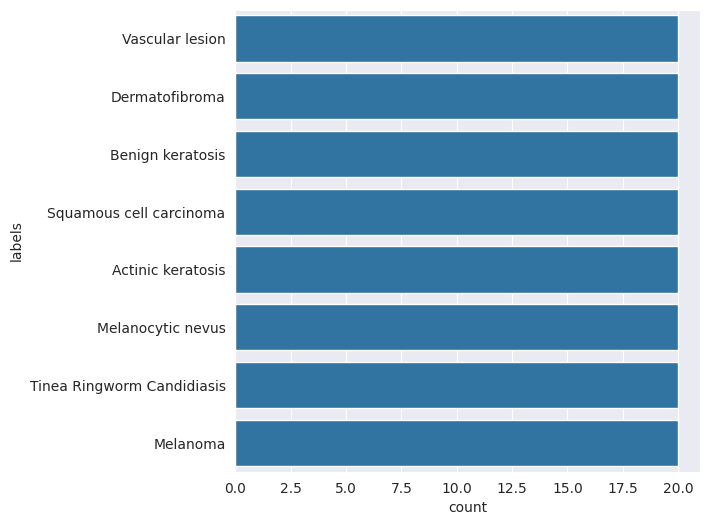

In [14]:
# Define source path
lung_path = "/content/dataset/val"

# Create a list that stores data for each filenames, filepaths, and labels in the data
file_name = []
labels = []
full_path = []

# Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Plot the distribution of images across the classes
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

## **6. preprocessing data**

### **Data Augmentasi dan Balancing**


In [21]:
src_base = "/content/dataset"  # Folder dataset awal berisi train/ dan val/
dst_base = "/content/balanced_skin_dataset"  # Folder output gabungan

train_min = 80  # Minimal gambar di train per kelas (setelah augmentasi)

os.makedirs(dst_base, exist_ok=True)

def augment_image(image):
    aug_choice = random.choice(['flip', 'brightness', 'rotate', 'contrast', 'crop'])
    if aug_choice == 'flip':
        return image.transpose(Image.FLIP_LEFT_RIGHT)
    elif aug_choice == 'brightness':
        enhancer = ImageEnhance.Brightness(image)
        return enhancer.enhance(random.uniform(0.8, 1.2))
    elif aug_choice == 'rotate':
        return image.rotate(random.choice([90, 180, 270]), expand=True)
    elif aug_choice == 'contrast':
        enhancer = ImageEnhance.Contrast(image)
        return enhancer.enhance(random.uniform(0.8, 1.3))
    elif aug_choice == 'crop':
        width, height = image.size
        crop_pct = 0.9
        crop_w, crop_h = int(width * crop_pct), int(height * crop_pct)
        left = (width - crop_w) // 2
        top = (height - crop_h) // 2
        image = image.crop((left, top, left + crop_w, top + crop_h))
        return image.resize((width, height))

# Ambil semua kelas dari train dan val (gabung list folder unik)
train_classes = [d for d in os.listdir(os.path.join(src_base, "train")) if os.path.isdir(os.path.join(src_base, "train", d))]
val_classes = [d for d in os.listdir(os.path.join(src_base, "val")) if os.path.isdir(os.path.join(src_base, "val", d))]
all_classes = sorted(list(set(train_classes + val_classes)))

print(f"Detected classes: {all_classes}")

for label in all_classes:
    print(f"\nProcessing class: {label}")

    train_folder = os.path.join(src_base, "train", label)
    val_folder = os.path.join(src_base, "val", label)
    out_folder = os.path.join(dst_base, label)
    os.makedirs(out_folder, exist_ok=True)

    # Ambil gambar train (kalau folder tidak ada, anggap kosong)
    train_images = []
    if os.path.exists(train_folder):
        train_images = [f for f in os.listdir(train_folder) if f.lower().endswith(('.jpg','.jpeg','.png'))]
    print(f"  Train images before augment: {len(train_images)}")

    # Augmentasi kalau kurang dari train_min
    if len(train_images) < train_min and len(train_images) > 0:
        deficit = train_min - len(train_images)
        print(f"  Augmenting {deficit} images to reach {train_min} in train set")
        for i in tqdm(range(deficit), desc=f"Augment train/{label}"):
            img_name = random.choice(train_images)
            img_path = os.path.join(train_folder, img_name)
            try:
                with Image.open(img_path) as img:
                    img = img.convert("RGB")
                    aug_img = augment_image(img)
                    aug_name = f"aug_{i}_{img_name}"
                    save_path = os.path.join(train_folder, aug_name)
                    aug_img.save(save_path)
                    train_images.append(aug_name)  # Tambah ke list
            except Exception as e:
                print(f"    Error augmentasi {img_name}: {e}")
    elif len(train_images) == 0:
        print(f"  Warning: No train images found for class {label}, skipping augmentation.")

    # Salin semua gambar train (setelah augmentasi) ke output
    for img_name in train_images:
        src_path = os.path.join(train_folder, img_name)
        dst_path = os.path.join(out_folder, img_name)
        if os.path.exists(src_path):
            shutil.copy(src_path, dst_path)

    # Salin semua gambar val ke output (jika ada)
    val_images = []
    if os.path.exists(val_folder):
        val_images = [f for f in os.listdir(val_folder) if f.lower().endswith(('.jpg','.jpeg','.png'))]
        print(f"  Val images: {len(val_images)}")
        for img_name in val_images:
            src_path = os.path.join(val_folder, img_name)
            dst_path = os.path.join(out_folder, img_name)
            if os.path.exists(src_path):
                shutil.copy(src_path, dst_path)
    else:
        print(f"  No val folder for class {label}")

    total_count = len(os.listdir(out_folder))
    print(f"  Total images in balanced folder for class '{label}': {total_count}")

print("\n✅ Dataset balancing dan penggabungan selesai!")
print("\n📊 Summary jumlah gambar per kelas di balanced_skin_dataset:")
for label in all_classes:
    folder = os.path.join(dst_base, label)
    count = len([f for f in os.listdir(folder) if f.lower().endswith(('.jpg','.jpeg','.png'))])
    print(f"  {label}: {count} gambar")


Detected classes: ['Actinic keratosis', 'Benign keratosis', 'Dermatofibroma', 'Melanocytic nevus', 'Melanoma', 'Squamous cell carcinoma', 'Tinea Ringworm Candidiasis', 'Vascular lesion']

Processing class: Actinic keratosis
  Train images before augment: 80
  Val images: 20
  Total images in balanced folder for class 'Actinic keratosis': 100

Processing class: Benign keratosis
  Train images before augment: 80
  Val images: 20
  Total images in balanced folder for class 'Benign keratosis': 100

Processing class: Dermatofibroma
  Train images before augment: 80
  Val images: 20
  Total images in balanced folder for class 'Dermatofibroma': 100

Processing class: Melanocytic nevus
  Train images before augment: 80
  Val images: 20
  Total images in balanced folder for class 'Melanocytic nevus': 100

Processing class: Melanoma
  Train images before augment: 80
  Val images: 20
  Total images in balanced folder for class 'Melanoma': 100

Processing class: Squamous cell carcinoma
  Train ima

Augment train/Tinea Ringworm Candidiasis: 100%|██████████| 10/10 [00:00<00:00, 27.68it/s]


  Val images: 20
  Total images in balanced folder for class 'Tinea Ringworm Candidiasis': 88

Processing class: Vascular lesion
  Train images before augment: 80
  Val images: 20
  Total images in balanced folder for class 'Vascular lesion': 100

✅ Dataset balancing dan penggabungan selesai!

📊 Summary jumlah gambar per kelas di balanced_skin_dataset:
  Actinic keratosis: 100 gambar
  Benign keratosis: 100 gambar
  Dermatofibroma: 100 gambar
  Melanocytic nevus: 100 gambar
  Melanoma: 100 gambar
  Squamous cell carcinoma: 100 gambar
  Tinea Ringworm Candidiasis: 88 gambar
  Vascular lesion: 100 gambar


In [22]:
target_total = 500  # Target total gambar per kelas setelah augmentasi

def augment_image(image):
    aug_choice = random.choice(['flip', 'brightness', 'rotate', 'contrast', 'crop'])
    if aug_choice == 'flip':
        return image.transpose(Image.FLIP_LEFT_RIGHT)
    elif aug_choice == 'brightness':
        enhancer = ImageEnhance.Brightness(image)
        return enhancer.enhance(random.uniform(0.8, 1.2))
    elif aug_choice == 'rotate':
        return image.rotate(random.choice([90, 180, 270]), expand=True)
    elif aug_choice == 'contrast':
        enhancer = ImageEnhance.Contrast(image)
        return enhancer.enhance(random.uniform(0.8, 1.3))
    elif aug_choice == 'crop':
        width, height = image.size
        crop_pct = 0.9
        crop_w, crop_h = int(width * crop_pct), int(height * crop_pct)
        left = (width - crop_w) // 2
        top = (height - crop_h) // 2
        image = image.crop((left, top, left + crop_w, top + crop_h))
        return image.resize((width, height))

balanced_base = "/content/balanced_skin_dataset"

classes = [d for d in os.listdir(balanced_base) if os.path.isdir(os.path.join(balanced_base, d))]

for label in classes:
    class_folder = os.path.join(balanced_base, label)
    images = [f for f in os.listdir(class_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    current_count = len(images)
    print(f"\nClass '{label}': current images = {current_count}")

    if current_count < target_total:
        deficit = target_total - current_count
        print(f"Augmenting {deficit} images for class '{label}'")
        for i in tqdm(range(deficit), desc=f"Augment {label}"):
            img_name = random.choice(images)
            img_path = os.path.join(class_folder, img_name)
            try:
                with Image.open(img_path) as img:
                    img = img.convert("RGB")
                    aug_img = augment_image(img)
                    aug_name = f"aug_{i}_{img_name}"
                    save_path = os.path.join(class_folder, aug_name)
                    aug_img.save(save_path)
                    images.append(aug_name)
            except Exception as e:
                print(f"Failed augmenting {img_name}: {e}")
    else:
        print(f"No augmentation needed for class '{label}'")

print("\n✅ Augmentasi selesai, berikut jumlah gambar per kelas setelah augmentasi:")
for label in classes:
    folder = os.path.join(balanced_base, label)
    count = len([f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    print(f"{label}: {count} gambar")



Class 'Vascular lesion': current images = 100
Augmenting 400 images for class 'Vascular lesion'


Augment Vascular lesion: 100%|██████████| 400/400 [00:02<00:00, 148.50it/s]



Class 'Dermatofibroma': current images = 100
Augmenting 400 images for class 'Dermatofibroma'


Augment Dermatofibroma: 100%|██████████| 400/400 [00:02<00:00, 150.00it/s]



Class 'Benign keratosis': current images = 100
Augmenting 400 images for class 'Benign keratosis'


Augment Benign keratosis: 100%|██████████| 400/400 [00:07<00:00, 55.35it/s]



Class 'Squamous cell carcinoma': current images = 100
Augmenting 400 images for class 'Squamous cell carcinoma'


Augment Squamous cell carcinoma: 100%|██████████| 400/400 [00:02<00:00, 153.93it/s]



Class 'Actinic keratosis': current images = 100
Augmenting 400 images for class 'Actinic keratosis'


Augment Actinic keratosis: 100%|██████████| 400/400 [00:02<00:00, 152.60it/s]



Class 'Melanocytic nevus': current images = 100
Augmenting 400 images for class 'Melanocytic nevus'


Augment Melanocytic nevus: 100%|██████████| 400/400 [00:06<00:00, 60.53it/s]



Class 'Tinea Ringworm Candidiasis': current images = 88
Augmenting 412 images for class 'Tinea Ringworm Candidiasis'


Augment Tinea Ringworm Candidiasis: 100%|██████████| 412/412 [00:11<00:00, 36.05it/s]



Class 'Melanoma': current images = 100
Augmenting 400 images for class 'Melanoma'


Augment Melanoma: 100%|██████████| 400/400 [00:05<00:00, 74.91it/s]


✅ Augmentasi selesai, berikut jumlah gambar per kelas setelah augmentasi:
Vascular lesion: 500 gambar
Dermatofibroma: 500 gambar
Benign keratosis: 500 gambar
Squamous cell carcinoma: 500 gambar
Actinic keratosis: 500 gambar
Melanocytic nevus: 500 gambar
Tinea Ringworm Candidiasis: 500 gambar
Melanoma: 500 gambar


**cek contoh gambar hasil augmentasi**

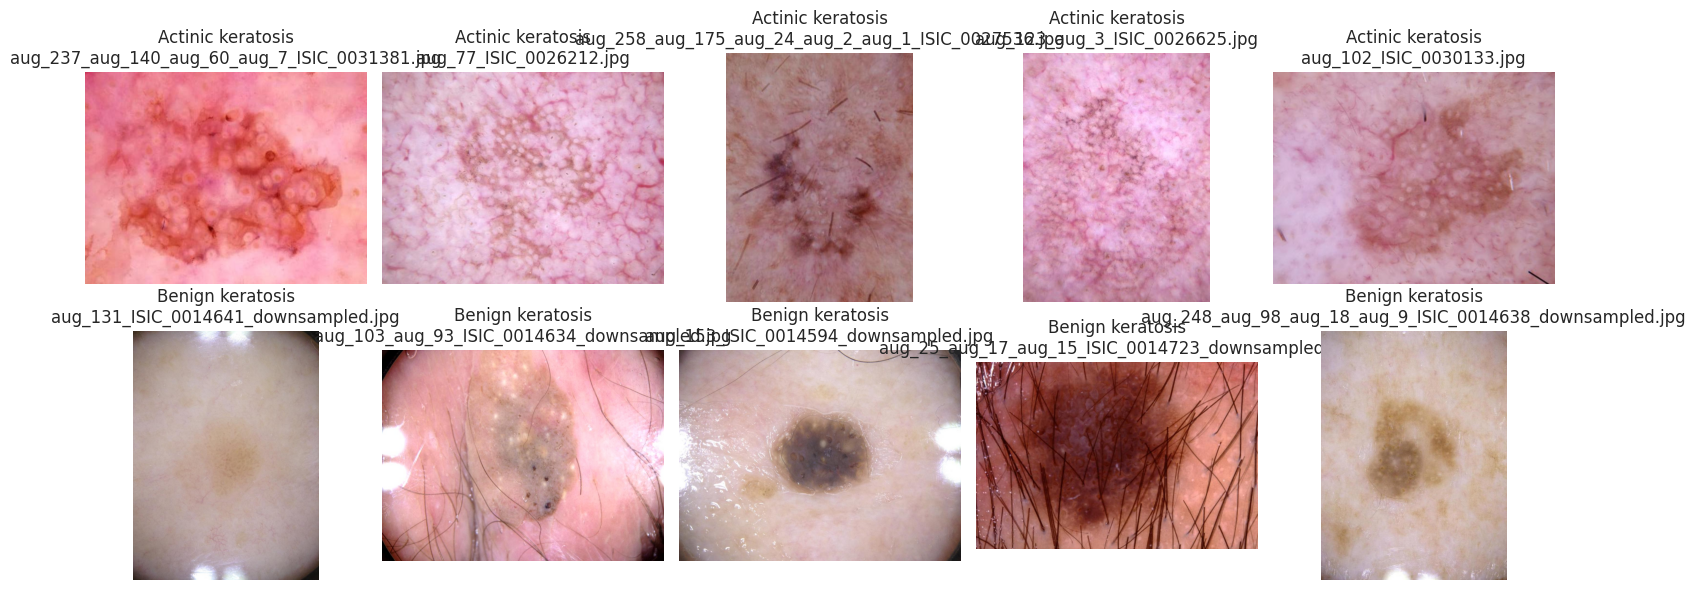

In [23]:
augmented_folders = []

for label in os.listdir(dst_base):
    folder_path = os.path.join(dst_base, label)
    if not os.path.isdir(folder_path):
        continue
    # Cek apakah ada file augmentasi (prefix 'aug_')
    aug_files = [f for f in os.listdir(folder_path) if f.startswith("aug_")]
    if aug_files:
        augmented_folders.append((label, aug_files))

# Pilih dua folder secara acak dari yang ada augmentasinya
selected_folders = random.sample(augmented_folders, 2)

# Tampilkan masing-masing 5 gambar hasil augmentasi
fig, axs = plt.subplots(2, 5, figsize=(15, 6))

for row, (label, aug_files) in enumerate(selected_folders):
    chosen_files = random.sample(aug_files, 5)
    for col, file_name in enumerate(chosen_files):
        img_path = os.path.join(dst_base, label, file_name)
        img = Image.open(img_path)
        axs[row, col].imshow(img)
        axs[row, col].set_title(f"{label}\n{file_name}")
        axs[row, col].axis('off')

plt.tight_layout()
plt.show()


### **Data Splitting : Training and Testing**

In [24]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= '/content/balanced_skin_dataset/'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)


# Memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

labels
Actinic keratosis             500
Benign keratosis              500
Dermatofibroma                500
Melanocytic nevus             500
Melanoma                      500
Squamous cell carcinoma       500
Tinea Ringworm Candidiasis    500
Vascular lesion               500
dtype: int64

In [25]:
# Variabel yang digunakan pada pemisahan data ini dimana variabel x = data path dan y = data labels
# Variabel X dan y
X = df['path']
y = df['labels']

# Stratified split untuk menjaga proporsi label di train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=300,
    stratify=y
)

In [26]:
# Menyatukan kedalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [27]:
# Print hasil diatas untuk melihat panjang size data training dan testing
print('train size', len(df_tr))
print('test size', len(df_te))

train size 3200
test size 800


In [28]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sample data
print(df_all.sample(5))


set    labels                    
test   Actinic keratosis             100
       Benign keratosis              100
       Dermatofibroma                100
       Melanocytic nevus             100
       Melanoma                      100
       Squamous cell carcinoma       100
       Tinea Ringworm Candidiasis    100
       Vascular lesion               100
train  Actinic keratosis             400
       Benign keratosis              400
       Dermatofibroma                400
       Melanocytic nevus             400
       Melanoma                      400
       Squamous cell carcinoma       400
       Tinea Ringworm Candidiasis    400
       Vascular lesion               400
dtype: int64 


                                                   path             labels  \
3893  /content/balanced_skin_dataset/Melanoma/aug_24...           Melanoma   
2496  /content/balanced_skin_dataset/Benign keratosi...   Benign keratosis   
2606  /content/balanced_skin_dataset/Benign keratosi...   B

In [29]:
# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = '/content/balanced_skin_dataset/'
# Membuat variabel Dataset, dimana nanti menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "/content/Dataset-Final/"

In [30]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

In [31]:

# Define training and test directories
TRAIN_DIR = "/content/Dataset-Final/train/"
TEST_DIR = "/content/Dataset-Final/test/"

# List kelas sesuai folder yang ada sekarang
classes = [
    "Actinic keratosis",
    "Benign keratosis",
    "Dermatofibroma",
    "Melanocytic nevus",
    "Melanoma",
    "Squamous cell carcinoma",
    "Tinea Ringworm Candidiasis",
    "Vascular lesion"
]

for cls in classes:
    train_path = os.path.join(TRAIN_DIR, cls)
    test_path = os.path.join(TEST_DIR, cls)

    train_count = len(os.listdir(train_path)) if os.path.exists(train_path) else 0
    test_count = len(os.listdir(test_path)) if os.path.exists(test_path) else 0

    print(f"Total number of {cls} images in training set: {train_count}")
    print(f"Total number of {cls} images in test set: {test_count}")
    print("-" * 50)


Total number of Actinic keratosis images in training set: 400
Total number of Actinic keratosis images in test set: 100
--------------------------------------------------
Total number of Benign keratosis images in training set: 400
Total number of Benign keratosis images in test set: 100
--------------------------------------------------
Total number of Dermatofibroma images in training set: 400
Total number of Dermatofibroma images in test set: 100
--------------------------------------------------
Total number of Melanocytic nevus images in training set: 400
Total number of Melanocytic nevus images in test set: 100
--------------------------------------------------
Total number of Melanoma images in training set: 400
Total number of Melanoma images in test set: 100
--------------------------------------------------
Total number of Squamous cell carcinoma images in training set: 400
Total number of Squamous cell carcinoma images in test set: 100
---------------------------------------

## **7. Image Data Generator**

In [32]:
# Dataset directories
TRAIN_DIR = "/content/Dataset-Final/train/"
TEST_DIR = "/content/Dataset-Final/test/"

# ImageDataGenerator untuk train/val (pakai preprocessing dari MobileNetV2 nanti)
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Train & validation generators
train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Test generator
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    batch_size=1,
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False
)

Found 2560 images belonging to 8 classes.
Found 640 images belonging to 8 classes.
Found 800 images belonging to 8 classes.


## **8. Modeling dengan MobileNetV2**

In [33]:
# Load MobileNetV2 sebagai base model
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze weights

# Tambahkan classifier di atasnya
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs, outputs)

# Compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │        10,248 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,268,232 (8.65 MB)

 Trainable params: 10,248 (40.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## **9. Training Model**

In [34]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_1 = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[early_stop]
)


Epoch 1/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 28s 221ms/step - accuracy: 0.4015 - loss: 1.6982 - val_accuracy: 0.7422 - val_loss: 0.8006
Epoch 2/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 171ms/step - accuracy: 0.7723 - loss: 0.6560 - val_accuracy: 0.7578 - val_loss: 0.6638
Epoch 3/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 174ms/step - accuracy: 0.8318 - loss: 0.4902 - val_accuracy: 0.7953 - val_loss: 0.5674
Epoch 4/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 15s 188ms/step - accuracy: 0.8419 - loss: 0.4450 - val_accuracy: 0.8188 - val_loss: 0.5264
Epoch 5/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 176ms/step - accuracy: 0.8865 - loss: 0.3579 - val_accuracy: 0.8266 - val_loss: 0.5069
Epoch 6/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 175ms/step - accuracy: 0.9033 - loss: 0.3006 - val_accuracy: 0.8391 - val_loss: 0.4766
Epoch 7/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 170ms/step - accuracy: 0.9257 - loss: 0.2577 - val_accuracy: 0.8531 - val_loss: 0.4511
Epoch 8/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 170ms/step - accuracy: 0.9323 - loss: 0.2443 - val_accu

## **10. Evaluasi Model**

In [35]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


800/800 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9462 - loss: 0.1932
Test Accuracy: 0.9550, Test Loss: 0.1393


## **11. Simpan Model**

In [36]:
# Simpan model
model.save("model_klasifikasi.h5")
